<a href="https://colab.research.google.com/github/spe301/dsc-phase-4-project/blob/main/Phase_4_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Data loading for csv and txt files
from google.colab import files
path_to_file = list(files.upload().keys())[0]

Saving judge-1377884607_tweet_product_company.csv to judge-1377884607_tweet_product_company.csv


In [2]:
import pandas as pd

df = pd.read_csv('judge-1377884607_tweet_product_company.csv', engine='python')

In [3]:
#dropping row 6 as there's no tweet in that row and dropping all rows where sentiment is "I can't tell"
df = df.drop(6)
df = df.loc[df['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

In [4]:
#stripping punctuation
ix = list(df.index)
clean = []
for i in range(len(ix)):
  clean.append(df['tweet_text'][ix[i]].replace('.@', '').replace('.', '').replace('!', '').replace('@', '').replace('?', '').replace(':', '')
  .replace(',', '').replace(';', '').lower())

df['tweet'] = clean

These are a some classes of helper functions that will make modeling and eda more efficient.

- Data Helper: data preprocessing
  - MulticlassOutput: output preprocessing
  - ModelReadyText1: converts tweets into tokenized sequences
  - ModelReadyText2: converts tweets into  one-hot-encoded vectors
  - ViewAccuracy: plots a model's accuracy throughout training
  - ViewLoss: plots a model's accuracy throughout training

- Deep Learning: model building and testing 
  - Powers: help the model building functions determine nlayers
  - Sparsity: help the model building function know when to use 'sparse_categorical_crossentropy' as loss function
  - FeedForward: builds a simple neural net with only Dense Layers
  - RNN: builds a neural network with LSTM or GRU layer(s)
  - TestDL: wraps the keras wrapper functions and GridSearchCV into a simple one liner, one line plus the parameter grid that is :)


In [131]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import models, layers
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from matplotlib import pyplot as plt
from math import log
from keras.regularizers import  L2, l1
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

class DataHelper:

  def MulticlassOutput(self, df, col):
    enc = OneHotEncoder()
    y = np.array(df[col]).reshape(-1, 1)
    oh = enc.fit_transform(y).toarray()
    return oh


  def ModelReadyText1(self, df, Xcol, ycol, pad):
    text = list(df[Xcol])
    t = Tokenizer()
    t.fit_on_texts(text)
    tokens = t.texts_to_sequences(text)
    tokens2 = pad_sequences(tokens, maxlen=pad)
    dh = DataHelper()
    y = dh.MulticlassOutput(df, ycol)
    return tokens2, y

  def ModelReadyText2(self, df, Xcol, ycol, num_words):
    dh = DataHelper()
    text = list(df[Xcol])
    t = Tokenizer(num_words=num_words)
    t.fit_on_texts(text)
    oh = t.texts_to_matrix(text)
    y = dh.MulticlassOutput(df, ycol)
    return oh, y

  def ViewAccuracy(self, history, epochs):
    plt.plot(range(epochs), history.history['accuracy'], label='train');
    plt.plot(range(epochs), history.history['val_accuracy'], label='val');
    plt.legend(loc='best')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    return None


  def ViewLoss(self, history, epochs):
      plt.plot(range(epochs), history.history['loss'], label='train');
      plt.plot(range(epochs), history.history['val_loss'], label='val');
      plt.legend(loc='best')
      plt.xlabel('epochs')
      plt.ylabel('loss')
      return None

class DeepLearning:

  def Powers(self, n):
    k = int(log(n, 2))
    return k

  def Sparsity(self, x):
    df = pd.DataFrame(x[0])
    df.columns = ['val']
    df2 = df.loc[df['val'] == 0]
    return len(df)*0.9 <= len(df2)

  def FeedForward(self, nodes, activation, optimizer, dropout, regularizer, inp, nclasses):
    dl = DeepLearning()
    if nclasses > 16:
      pen = nclasses*2
    else:
      pen = 16
    if nclasses == 2:
      oa = 'sigmoid'
      loss = 'binary_crossentropy'
    else:
      oa = 'softmax'
      if dl.Sparsity(X) == False:
        loss = 'categorical_crossentropy'
      else:
        loss = 'sparse_categorical_crossentropy'
    model = models.Sequential()
    if regularizer == None:
      model.add(layers.Dense(nodes, activation=activation, input_shape=(inp,)))
    if regularizer == 'L1':
      model.add(layers.Dense(nodes, activation=activation, input_shape=(inp,), kernel_regularizer=l1(0.005)))
    if regularizer == 'L2':
      model.add(layers.Dense(nodes, activation=activation, input_shape=(inp,), kernel_regularizer=L2(0.005)))
    if dropout == True:
      model.add(layers.Dropout(0.5))
    p = dl.Powers(nodes)
    for i in range(p):
      nodes /= 2
      nodes = int(nodes)
      if nodes > 16:
        if nodes > nclasses:
          model.add(layers.Dense(nodes, activation=activation))
    model.add(layers.Dense(pen, activation=activation))
    model.add(layers.Dense(nclasses, activation=oa))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

  def RNN(self, nodes, activation, optimizer, dropout, regularizer, method, stacking, inp, nclasses):
    dl = DeepLearning()
    if nclasses > 16:
      pen = nclasses*2
    else:
      pen = 16
    if nclasses == 2:
      oa = 'sigmoid'
      loss = 'binary_crossentropy'
    else:
      oa = 'softmax'
      if dl.Sparsity(X) == False:
        loss = 'categorical_crossentropy'
      else:
        loss = 'sparse_categorical_crossentropy'  
    model = models.Sequential()
    model.add(layers.Embedding(inp, nodes))
    if method == 'LSTM':
      if regularizer == None:
        model.add(layers.LSTM(nodes, activation=activation, return_sequences=stacking))
      if regularizer == 'L1':
        model.add(layers.LSTM(nodes, activation=activation, kernel_regularizer=l1(0.005), return_sequences=stacking))
      if regularizer == 'L2':
        model.add(layers.LSTM(nodes, activation=activation, kernel_regularizer=L2(0.005), return_sequences=stacking))
    if method == 'GRU':
      if regularizer == None:
        model.add(layers.GRU(nodes, activation=activation, return_sequences=stacking))
      if regularizer == 'L1':
        model.add(layers.GRU(nodes, activation=activation, kernel_regularizer=l1(0.005), return_sequences=stacking))
      if regularizer == 'L2':
        model.add(layers.GRU(nodes, activation=activation, kernel_regularizer=L2(0.005), return_sequences=stacking))
    if dropout == True:
      model.add(layers.Dropout(0.5))
    dl = DeepLearning()
    if stacking == True:
      nodes = nodes//2
      if method == 'LSTM':
        model.add(layers.LSTM(nodes, activation=activation))
      else:
        model.add(layers.GRU(nodes, activation=activation))
    p = dl.Powers(nodes)
    for i in range(p):
      nodes /= 2
      nodes = int(nodes)
      if nodes > 16:
        if nodes > nclasses:
          model.add(layers.Dense(nodes, activation=activation))
    model.add(layers.Dense(pen, activation=activation))
    model.add(layers.Dense(nclasses, activation=oa))
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

  def TestDL(self, params, func, task, X, y, X_val=None, y_val=None, batch_size=64, epochs=50):
    early_stopping = [EarlyStopping(patience=10), ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5')]
    if task == 'classification':
      k = KerasClassifier(func)
    if task == 'regression':
      k = KerasRegressor(func)
    grid = GridSearchCV(k, params, cv=3)
    if type(X_val) != np.ndarray:
      grid.fit(X, y, batch_size=batch_size, epochs=epochs, validation_split=0.2)
    else:
      grid.fit(X, y, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=early_stopping)
    return grid.best_params_

In [6]:
dh = DataHelper()
dl = DeepLearning()
X, y = dh.ModelReadyText1(df, 'tweet', 'is_there_an_emotion_directed_at_a_brand_or_product', pad=33)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [7]:
def Bidirectional(vocab, nodes, output, optimizer, metrics, activation):
  if output == 1:
    oa = 'linear'
    loss = 'mse'
  if output == 2:
    oa = 'sigmoid'
    loss = 'binary_crossentropy'
  else:
    oa = 'softmax'
    loss = 'categorical_crossentropy'
  model = models.Sequential()
  model.add(layers.Embedding(vocab, nodes)) 
  model.add(layers.Bidirectional(layers.LSTM(nodes))) 
  model.add(layers.Dense(nodes/2, activation=activation))
  model.add(layers.Dense(nodes/4, activation=activation))
  model.add(layers.Dense(output, activation=oa))
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  return model

B = Bidirectional(21444, 64, 3, 'adam', ['accuracy'], 'relu')
early_stopping = [EarlyStopping(patience=10), ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5')]
B.summary()
B.fit(X_train, y_train, batch_size=64, epochs=50, callbacks=early_stopping, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          1372416   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
Total params: 1,443,171
Trainable params: 1,443,171
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
101/101 [==============================] - 3s 28ms/step - loss: 0.8705 - accuracy: 0.5989 - val_loss:

In [ ]:
params = {'nodes': [50, 64, 128, 256], 'activation': ['relu', 'tanh'], 'optimizer': ['rmsprop', 'adam'], 'metrics': ['accuracy'], 'vocab': [21444], 'output': [3]}

dl.TestDL(params, Bidirectional, 'classification', X_train, y_train, X_val=X_val, y_val=y_val)

Epoch 1/50
56/56 [==============================] - 1s 25ms/step - loss: 0.8734 - accuracy: 0.5887 - val_loss: 0.8077 - val_accuracy: 0.6163
Epoch 2/50
56/56 [==============================] - 1s 15ms/step - loss: 0.7723 - accuracy: 0.6388 - val_loss: 0.7872 - val_accuracy: 0.6387
Epoch 3/50
56/56 [==============================] - 1s 15ms/step - loss: 0.6524 - accuracy: 0.7294 - val_loss: 0.7693 - val_accuracy: 0.6588
Epoch 4/50
56/56 [==============================] - 1s 15ms/step - loss: 0.5526 - accuracy: 0.7784 - val_loss: 0.8426 - val_accuracy: 0.6661
Epoch 5/50
56/56 [==============================] - 1s 14ms/step - loss: 0.4664 - accuracy: 0.8125 - val_loss: 0.8605 - val_accuracy: 0.6538
Epoch 6/50
56/56 [==============================] - 1s 15ms/step - loss: 0.3960 - accuracy: 0.8511 - val_loss: 0.8981 - val_accuracy: 0.6572
Epoch 7/50
56/56 [==============================] - 1s 14ms/step - loss: 0.3317 - accuracy: 0.8763 - val_loss: 0.8113 - val_accuracy: 0.6628
Epoch 8/50
56

{'activation': 'relu',
 'metrics': 'accuracy',
 'nodes': 128,
 'optimizer': 'adam',
 'output': 3,
 'vocab': 21444}

In [8]:
model = models.Sequential()
model.add(layers.Embedding(21444, 128))
model.add(layers.Bidirectional(layers.LSTM(128)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=early_stopping)
model.save('bid.h5')

Epoch 1/50
101/101 [==============================] - 4s 44ms/step - loss: 0.8504 - accuracy: 0.5954 - val_loss: 0.8064 - val_accuracy: 0.6128
Epoch 2/50
101/101 [==============================] - 4s 36ms/step - loss: 0.6516 - accuracy: 0.7084 - val_loss: 0.7214 - val_accuracy: 0.6942
Epoch 3/50
101/101 [==============================] - 4s 37ms/step - loss: 0.4233 - accuracy: 0.8289 - val_loss: 0.7971 - val_accuracy: 0.6762
Epoch 4/50
101/101 [==============================] - 4s 37ms/step - loss: 0.3011 - accuracy: 0.8829 - val_loss: 0.8375 - val_accuracy: 0.7023
Epoch 5/50
101/101 [==============================] - 4s 36ms/step - loss: 0.2423 - accuracy: 0.9042 - val_loss: 0.9365 - val_accuracy: 0.6768
Epoch 6/50
101/101 [==============================] - 4s 37ms/step - loss: 0.2104 - accuracy: 0.9123 - val_loss: 0.9887 - val_accuracy: 0.6899
Epoch 7/50
101/101 [==============================] - 4s 36ms/step - loss: 0.1767 - accuracy: 0.9246 - val_loss: 1.0431 - val_accuracy: 0.6712

In [9]:
model.evaluate(X_test, y_test, batch_size=64)

14/14 [==============================] - 0s 6ms/step - loss: 1.8336 - accuracy: 0.6532


[1.8336397409439087, 0.6532438397407532]

In [10]:
model.evaluate(X_train, y_train, batch_size=64)

126/126 [==============================] - 1s 5ms/step - loss: 0.3897 - accuracy: 0.9004


[0.38971319794654846, 0.9003978967666626]

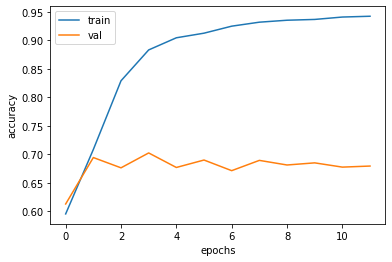

In [11]:
dh.ViewAccuracy(history, 12)

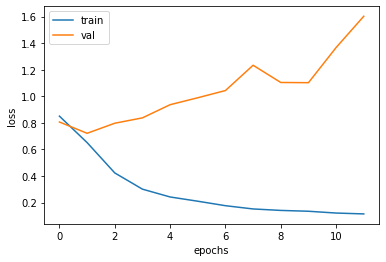

In [12]:
dh.ViewLoss(history, 12)

I was planning on doing another gridsearch on my RNN building function to test out LSTM's and GRU's of varying sizes. However I'm going to do something about class imbalances first. Although I deleted these cells for some reason, I realized that the only way to stop the model from overfitting was to use l1 regularization. However, train and validation accuracy just stay around 60% which is interesting because ~60% of the data is of one class.

In [13]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

I went back into my network building functions to parameritize metrics. if you look at the code it's already fixed but just note that accuracy was originally hardcoded as the metric for the models.

In [14]:
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight('balanced',
                                np.unique(df['is_there_an_emotion_directed_at_a_brand_or_product']),
                                df['is_there_an_emotion_directed_at_a_brand_or_product'])

weights_dict = dict(zip(range(3), weights))
weights_dict

{0: 5.2257309941520464, 1: 0.5528334570650829, 2: 1.0002238638907543}

In [15]:
from keras.metrics import Recall, Precision

model = models.Sequential()
model.add(layers.Embedding(21444, 128))
model.add(layers.Bidirectional(layers.LSTM(128)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=early_stopping, class_weight=weights_dict)

Epoch 1/50
101/101 [==============================] - 4s 40ms/step - loss: 1.0404 - accuracy: 0.5024 - val_loss: 0.9062 - val_accuracy: 0.5500
Epoch 2/50
101/101 [==============================] - 3s 35ms/step - loss: 0.6891 - accuracy: 0.6771 - val_loss: 0.8535 - val_accuracy: 0.5960
Epoch 3/50
101/101 [==============================] - 4s 35ms/step - loss: 0.4141 - accuracy: 0.8062 - val_loss: 0.9926 - val_accuracy: 0.5966
Epoch 4/50
101/101 [==============================] - 3s 35ms/step - loss: 0.2780 - accuracy: 0.8610 - val_loss: 0.9425 - val_accuracy: 0.6476
Epoch 5/50
101/101 [==============================] - 4s 35ms/step - loss: 0.2178 - accuracy: 0.8889 - val_loss: 1.0205 - val_accuracy: 0.6408
Epoch 6/50
101/101 [==============================] - 4s 35ms/step - loss: 0.1837 - accuracy: 0.9044 - val_loss: 1.0740 - val_accuracy: 0.6464
Epoch 7/50
101/101 [==============================] - 3s 34ms/step - loss: 0.1644 - accuracy: 0.9117 - val_loss: 1.0860 - val_accuracy: 0.6526

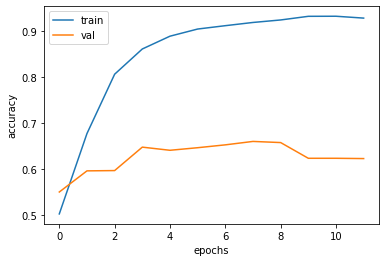

In [16]:
dh.ViewAccuracy(history, 12)

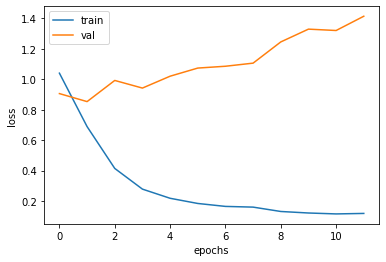

In [17]:
dh.ViewLoss(history, 12)

I would do an exaustive gridsearch on my RNN building function to test out LSTM's and GRU's of varying parameters and sizes. however fixing class imbalances didn't help and I don't want to waste compute. I will instead use glove embeddings rather than creating my own embedding layer. I will also try a traditional machine learning approach later on.

In [18]:
tokens = []
for num in ix:
  tokens.append(df['tweet'][num].split(' '))

In [19]:
from gensim.models import Word2Vec, keyedvectors

W = Word2Vec(tokens, size=33, window=3, min_count=1, workers=4)
W.train(sentences=tokens, total_examples=W.corpus_count, epochs=10)
wv = W.wv

In [20]:
e = W.wv.get_keras_embedding(train_embeddings=False)

In [24]:
from keras.metrics import Recall

model = models.Sequential()
model.add(e)
model.add(layers.Bidirectional(layers.LSTM(128)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = [EarlyStopping(patience=10), ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5')]

history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, callbacks=early_stopping, class_weight=weights_dict)

Epoch 1/50
101/101 [==============================] - 2s 16ms/step - loss: 1.0752 - accuracy: 0.3676 - val_loss: 1.2630 - val_accuracy: 0.2231
Epoch 2/50
101/101 [==============================] - 1s 9ms/step - loss: 1.0432 - accuracy: 0.3952 - val_loss: 1.0083 - val_accuracy: 0.4549
Epoch 3/50
101/101 [==============================] - 1s 10ms/step - loss: 1.0143 - accuracy: 0.4124 - val_loss: 1.0885 - val_accuracy: 0.4027
Epoch 4/50
101/101 [==============================] - 1s 10ms/step - loss: 0.9898 - accuracy: 0.4631 - val_loss: 1.0881 - val_accuracy: 0.4288
Epoch 5/50
101/101 [==============================] - 1s 9ms/step - loss: 0.9609 - accuracy: 0.4629 - val_loss: 0.9884 - val_accuracy: 0.4897
Epoch 6/50
101/101 [==============================] - 1s 10ms/step - loss: 0.9206 - accuracy: 0.4923 - val_loss: 1.0961 - val_accuracy: 0.3679
Epoch 7/50
101/101 [==============================] - 1s 10ms/step - loss: 0.8985 - accuracy: 0.4862 - val_loss: 0.9297 - val_accuracy: 0.5071
E

In [25]:
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,wesley83 i have a 3g iphone after 3 hrs tweeti...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,jessedee know about fludapp awesome ipad/ipho...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,swonderlin can not wait for #ipad 2 also they ...
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,sxsw i hope this year's festival isn't as cras...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,sxtxstate great stuff on fri #sxsw marissa may...
...,...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion,ipad everywhere #sxsw {link}
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product,wave buzz rt mention we interrupt your regular...
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product,google's zeiger a physician never reported pot...
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product,some verizon iphone customers complained their...


In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [27]:
stopwords_list = nltk.corpus.stopwords.words('english')

In [28]:
vocab = []
for token in tokens:
  if token not in stopwords_list:
    vocab += token

wrds = list(set(vocab))

In [29]:
glove = {}
for w in wrds:
  glove[w] = wv.get_vector(w)

In [30]:
class W2vVectorizer(object):

  def __init__(self, w2v):
    self.w2v = w2v
    if len(w2v) == 0:
      self.dimensions = 0
    else:
      self.dimensions = len(w2v[next(iter(glove))])

  def fit(self, X, y):
    return self

  def transform(self, X):
    return np.array([
        np.mean([self.w2v[w] for w in words if w in self.w2v]
            or [np.zeros(self.dimensions)], axis=0) for words in X])

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression())])

In [32]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Logistic Regression', lr)]

w2v = W2vVectorizer(glove)

data2 = pd.Series(tokens)

In [33]:
scores = [(name, cross_val_score(model, data2, y, cv=2, n_jobs=-1).mean()) for name, model in models]

In [34]:
scores

[('Random Forest', 0.534579230080573),
 ('Support Vector Machine', nan),
 ('Logistic Regression', nan)]

Trying a different approach! I one hot encoded each tweet for all of the words in the corpus. I will use PCA to compress the very sparse data

In [35]:
X_oh, y_oh = dh.ModelReadyText2(df, 'tweet', 'is_there_an_emotion_directed_at_a_brand_or_product', len(glove))

In [36]:
classes = []
for arr in y_oh:
  classes.append(arr.argmax())

In [37]:
df2 = pd.DataFrame(X_oh)
df2['target'] = classes
df2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12319,12320,12321,12322,12323,12324,12325,12326,12327,12328,12329,12330,12331,12332,12333,12334,12335,12336,12337,12338,12339,12340,12341,12342,12343,12344,12345,12346,12347,12348,12349,12350,12351,12352,12353,12354,12355,12356,12357,target
0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8931,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
8932,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8933,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
8934,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [40]:
from sklearn.decomposition import PCA

pca = PCA(n_components=290)

X = df2.drop(['target'], axis='columns')

df3 = pd.DataFrame(pca.fit_transform(X))

In [41]:
df3['target'] = classes

In [42]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import  KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, AdaBoostRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_iris
from xgboost import XGBClassifier, XGBRegressor
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest
from statsmodels.stats.outliers_influence import variance_inflation_factor

class MachineLearning:
    
    def CompareClassifiers(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        n = len(np.unique(y))
        if n == 2:
            methods = [KNeighborsClassifier(), GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier(),
                      AdaBoostClassifier(), GradientBoostingClassifier(), XGBClassifier(), LogisticRegression(),
                      SVC()]
            strs = ['KNN', 'NB', 'DT', 'RF', 'AB', 'GB', 'XGB', 'Log', 'SVM']
        else:
            methods = [KNeighborsClassifier(), DecisionTreeClassifier(), RandomForestClassifier(),
                       AdaBoostClassifier(), GradientBoostingClassifier(), XGBClassifier(), SVC()]
            strs = ['KNN', 'DT', 'RF', 'AB', 'GB', 'XGB', 'SVM']
        train_acc = []
        test_acc = []
        for i in range(len(methods)):
            clf = methods[i].fit(X_train, y_train)
            train_acc.append(clf.score(X_train, y_train))
            test_acc.append(clf.score(X_test, y_test))
        c1 = pd.DataFrame(strs)
        c2 = pd.DataFrame(train_acc)
        c3 = pd.DataFrame(test_acc)
        results = pd.concat([c1, c2, c3], axis='columns')
        results.columns = ['Model', 'train_acc', 'test_acc']
        return results
    
    def CompareRegressors(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        n = len(np.unique(y))
        methods = [LinearRegression(), KNeighborsRegressor(), DecisionTreeRegressor(), RandomForestRegressor(),
                       AdaBoostRegressor(), GradientBoostingRegressor(), XGBRegressor(), SVR()]
        strs = ['Lin', 'KNN', 'DT', 'RF', 'AB', 'GB', 'XGB', 'SVM']
        train_acc = []
        test_acc = []
        for i in range(len(methods)):
            reg = methods[i].fit(X_train, y_train)
            train_acc.append(reg.score(X_train, y_train))
            test_acc.append(reg.score(X_test, y_test))
        c1 = pd.DataFrame(strs)
        c2 = pd.DataFrame(train_acc)
        c3 = pd.DataFrame(test_acc)
        results = pd.concat([c1, c2, c3], axis='columns')
        results.columns = ['Model', 'train_acc', 'test_acc']
        return results
    
    def Optimize(self, model, parameters, X, y, metric='accuracy'):
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
            return GridSearchCV(model, parameters, cv=5, scoring=metric, n_jobs=-1, verbose=2).fit(X_train, y_train).best_estimator_
        except:
            return GridSearchCV(model, parameters, cv=5, n_jobs=-1, verbose=2).fit(X_train, y_train).best_estimator_
        
    def PipeIt(self, scaler, model, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        pipe = Pipeline([('scaler', scaler), ('model', model)]).fit(X_train, y_train)
        return "Training: {}, Validation: {}".format(pipe.score(X_train, y_train), pipe.score(X_test, y_test))


class DataHelper:
    
    def ScaleData(self, strategy, y_var, data):
        X = data.drop([y_var], axis='columns')
        if strategy == 'minmax':
            return MinMaxScaler().fit(X).transform(X)
        if strategy == 'standard':
            return StandardScaler().fit(X).transform(X)
        if strategy == 'mean':
            for col in X.columns:
                X[col] = (X[col] - min(X[col]))/ (max(X[col]) - min(X[col]))
            return X
        
    def HoldOut(self, data):
        train, test = train_test_split(data, test_size=0.1)
        return train, test
    
    def MakeNewDF(self, X, y, k):
        selector = SelectKBest(k=k).fit(X, y)
        mask = selector.get_support()
        selected = []
        for i in range(len(mask)):
            if mask[i] == True:
                selected.append(X.columns[i])
        df = pd.DataFrame(selector.transform(X))
        df.columns = selected
        return df
    
    def VifIt(self, X):
        vif = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)
        return vif
        
    
class Evaluater:
    
    def ScoreModel(self, model, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        algo = model.fit(X_train, y_train)
        return 'Training: {}, Validation: {}'.format(algo.score(X_train, y_train), algo.score(X_test, y_test))
    
    def BuildConfusion(self, fitted_model,  Xval, yval, cmap='plasma'):
        cm = plot_confusion_matrix(fitted_model, Xval, yval, cmap=cmap)
        return cm
    
    def BuildTree(self, tree):
        try:
            return plot_tree(tree)
        except:
            return 'Please pass a tree class'
    
    def GetCoefficients(self, model, X, y):
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
            model.fit(X_train, y_train)
            return 'coefficients: {}'.format(model.coef_)
        except:
            return 'Please pass LinearRegression, LogisticRegression, or an SVM with a linear kernel'
        
    def GetImportance(self, model, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
        model.fit(X_train, y_train)
        try:
            FI = model.feature_importances_
            n_features = X_train.shape[1]
            plt.figure(figsize=(8,8))
            plt.barh(range(n_features), FI, align='center') 
            plt.yticks(np.arange(n_features), X_train.columns.values) 
            plt.xlabel('Feature importance')
            plt.ylabel('Feature')
        except:
            return 'Please pass an ensemble class'
        
    def AUC(self, model, Xval, yval):
        pred = model.predict(Xval)
        fpr, tpr, threshold = roc_curve(yval, pred)
        return auc(fpr, tpr)
    
ml = MachineLearning()
dh2 = DataHelper()
ev = Evaluater()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [43]:
X_train = dh2.HoldOut(df3)[0].drop(['target'], axis='columns')
y_train = dh2.HoldOut(df3)[0]['target']
X_test = dh2.HoldOut(df3)[1].drop(['target'], axis='columns')
y_test = dh2.HoldOut(df3)[1]['target']

In [44]:
model = XGBClassifier()

model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [45]:
model.score(X_test, y_test)

0.5928411633109619

In [46]:
model.score(X_train, y_train)

0.6457348918179557

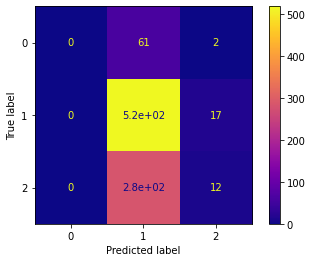

In [47]:
ev.BuildConfusion(model, X_test, y_test)

In [48]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_res, y_res = sm.fit_resample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [49]:
xgb = XGBClassifier()
xgb.fit(X_res, y_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [50]:
xgb.score(X_res, y_res)

0.7059227232173495

In [51]:
xgb.score(np.array(X_test), np.array(y_test))

0.4395973154362416

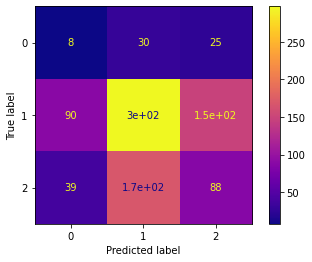

In [52]:
ev.BuildConfusion(xgb, np.array(X_test), np.array(y_test))

After trying various RNN's and gradient boosted forests trained on word embeddings, and trained on a PCA transformed one hot encoded vectors. I've concluded that the RNN saved as 'bid.h5' was the best. Although it was overfit it got 94% accuracy. I will now access random tweets outside of the dataset via the twitter API and see how the model classifies the tweets

In [56]:
from keras import models

model = models.load_model('bid.h5')

In [61]:
from google.colab import files
path_to_file = list(files.upload().keys())[0]

Saving ssh-twitter.txt to ssh-twitter.txt


In [176]:
import tweepy

c1 = open('ssh-twitter.txt').readlines()[2].split(':')[1].replace('\n', '').replace(' ', '')
c2 = open('ssh-twitter.txt').readlines()[3].split(':')[1].replace('\n', '').replace(' ', '')
a1 = open('ssh-twitter.txt').readlines()[0].split(':')[1].replace('\n', '').replace(' ', '')
a2 = open('ssh-twitter.txt').readlines()[1].split(':')[1].replace('\n', '').replace(' ', '')

auth = tweepy.OAuthHandler(c1, c2)
auth.set_access_token(a1, a2)

def GetTweets(Topic):
  api = tweepy.API(auth)
  topic = api.search(Topic)
  tweets = []
  time = []
  for i in range(len(topic)):
    tweets.append(topic[i]._json['text'].replace('\n', '').replace('.@', '').replace('.', '').replace('!', '').replace('@', '')
    .replace('?', '').replace(':', '').replace(',', '').replace(';', '').lower())
    time.append(topic[i]._json['created_at'])
    res = pd.DataFrame(tweets)
  res.columns = ['text']
  res['time'] = time 
  X = dh.ModelReadyText1(res, 'text', 'time', 33)[0]
  backup_dim = len(X), len(res)
  sent = []
  for arr in X:
    sentiment = int(round(model.predict(arr).argmax()/len(arr)-1))
    if sentiment == 0:
      sent.append('Negative')
    if sentiment == 1:
      sent.append('Neutral')
    if sentiment == 2:
      sent.append('Positive')
  res['sentiment'] = sent 
  results = res.drop(['time'], axis='columns')
  return results

With this GetTweets function all you have to do is enter a topic and you'll get a dataframe with tweets selected by the tweepy module and the sentiment that the model predicts!

In [177]:
GetTweets('Covid')

,text,sentiment
0,rt luiscarrillo66 descubren que el covid-19 ya...,Neutral
1,rt shanabc04 les gens qui aiment pas l’album d...,Neutral
2,rt drericding covid killed christmas for our k...,Neutral
3,shekhargupta meher70090510 _yogendrayadav our ...,Positive
4,rt thedailyshow a staten island bar owner who ...,Negative
5,rt muyregiaa mis logros de este año1- no tuve ...,Neutral
6,rt sandra_barba ahora me entero de que hay un ...,Neutral
7,"rt facesofcovid robert ""bobby"" sullivan 72 of ...",Positive
8,rt escritoslana llegué a diciembre sin tener c...,Positive
9,rt partidopsuv día 269 de la lucha contra la c...,Negative
